In [5]:
import torch
import torchvision
import torch.nn as nn
import os

import matplotlib.pyplot as plt
import wandb

from data_loader import Dataset
from models import UNet, HeatNetWrapper 
from data_loader import DeviceDict

# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

# setting up the dataset and train/val splits
dataset = "sample_DeepFashion"
df = Dataset(dataset=dataset)
indices_train = list(range(0, 90))
train_set = torch.utils.data.Subset(df, indices_train)
indices_test = list(range(90, 100))
test_set = torch.utils.data.Subset(df, indices_test)


#set parameters
epochs = 100
batch_size = 16
accumulation_steps = 2

# define the dataset loader (batch size, shuffling, ...)
collate_fn_device = lambda batch : DeviceDict(torch.utils.data.dataloader.default_collate(batch)) # collate_fn_device is necessary to preserve our custom dictionary during the collection of samples fetched from the dataset into a Tensor batch. 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, num_workers=4, pin_memory=False, shuffle=True, drop_last=True, collate_fn=collate_fn_device) # Note, setting pin_memory=False to avoid the pin_memory call
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 2, num_workers=4, pin_memory=False, shuffle=False, drop_last=True, collate_fn=collate_fn_device) # Note, setting pin_memory=False to avoid the pin_memory call

# define models
n_app_features = 3
num_joints = 15
model = "PD"

int_network = HeatNetWrapper(torchvision.models.segmentation.deeplabv3_resnet50(num_classes=num_joints)).cuda()
# int_network = nn.DataParallel(int_network)

decoder = UNet(n_channels= n_app_features, n_classes=3, bilinear=True).cuda()
# decoder = nn.DataParallel(decoder)

#count model params
int_params = sum(p.numel() for p in int_network.parameters() if p.requires_grad)
dec_params = sum(p.numel() for p in decoder.parameters() if p.requires_grad)
print("params:", int_params, dec_params)
print(f'Memory allocated after loading models: {torch.cuda.memory_allocated()/1000000000} ')


## WandB
config_dict = {"dataset": dataset,  
              "n_app_features": n_app_features,
              "num_joints": num_joints,
              "epochs": epochs,
              "batch_size": batch_size}

wandb.init(name = model+"_"+ dataset+ str(num_joints), project= "PD", config= config_dict)

Loading dataset to memory, can take some seconds
.. done loading
params: 39637327 17267523
Memory allocated after loading models: 0.231475712 


wandb: Wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/fjavadi/PD/runs/1wiw212v

In [2]:
# load models
decoder.load_state_dict(torch.load("saved_models/PD_decoder.pt"))
int_network.load_state_dict(torch.load("saved_models/PD_int_network.pt"))

<All keys matched successfully>

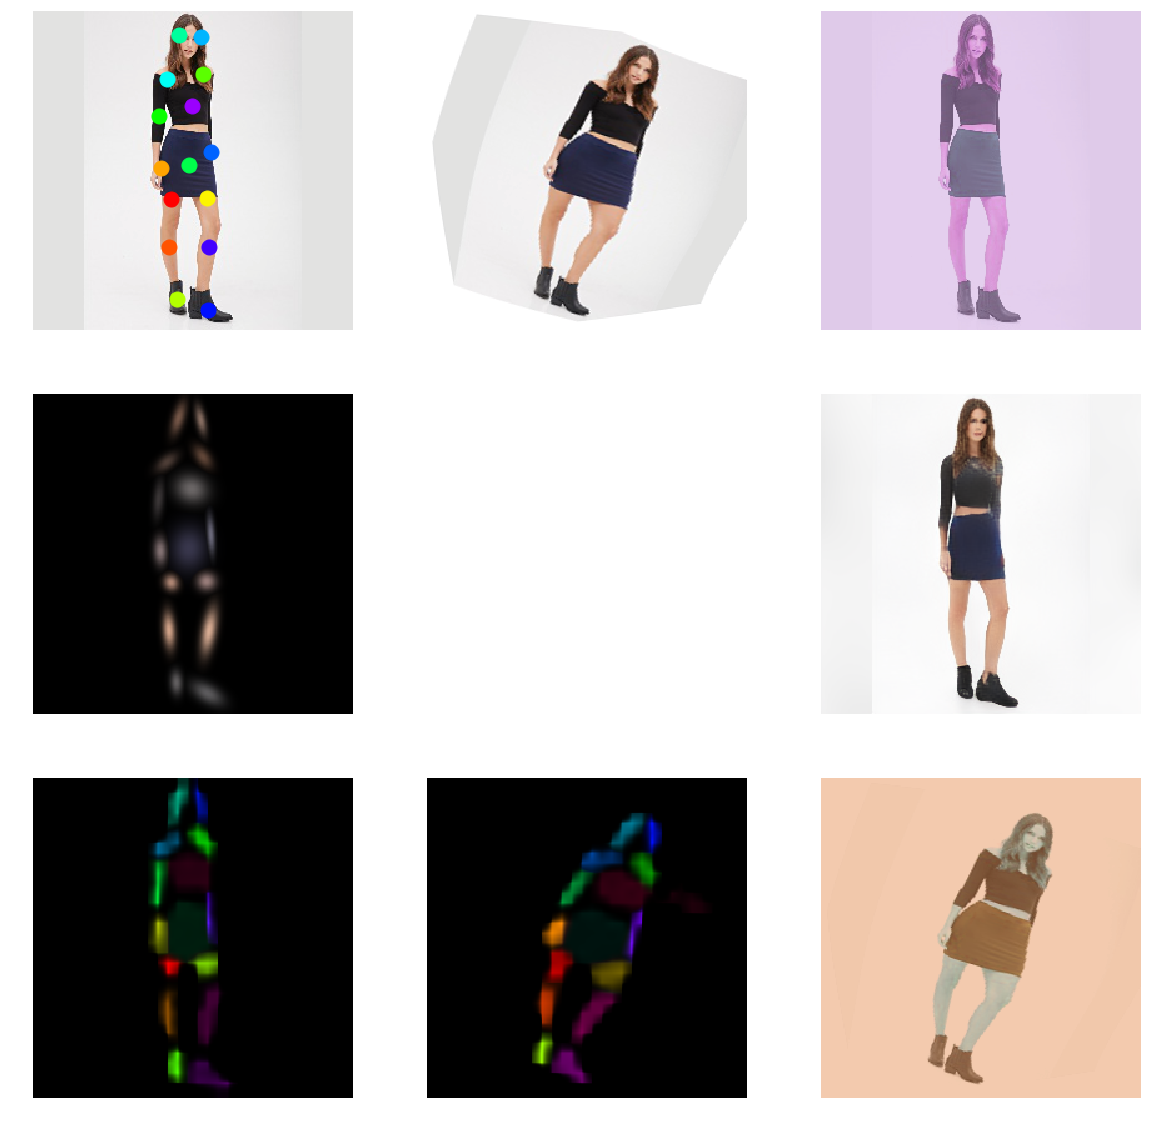

Epoch 0, iteration 0 of 11 (0 %), loss=0, 0, 0
Epoch 0, iteration 1 of 11 (9 %), loss=0.20299389958381653, 1.0996248722076416, 0.09303142130374908
Epoch 0, iteration 2 of 11 (18 %), loss=0.20299389958381653, 1.0996248722076416, 0.09303142130374908
Epoch 0, iteration 3 of 11 (27 %), loss=0.22928886115550995, 1.1704189777374268, 0.11224696040153503
Epoch 0, iteration 4 of 11 (36 %), loss=0.22928886115550995, 1.1704189777374268, 0.11224696040153503
Epoch 0, iteration 5 of 11 (45 %), loss=0.20019349455833435, 1.1166646480560303, 0.08852702379226685
Epoch 0, iteration 6 of 11 (54 %), loss=0.20019349455833435, 1.1166646480560303, 0.08852702379226685
Epoch 0, iteration 7 of 11 (63 %), loss=0.20988088846206665, 1.1598725318908691, 0.0938936322927475


KeyboardInterrupt: 

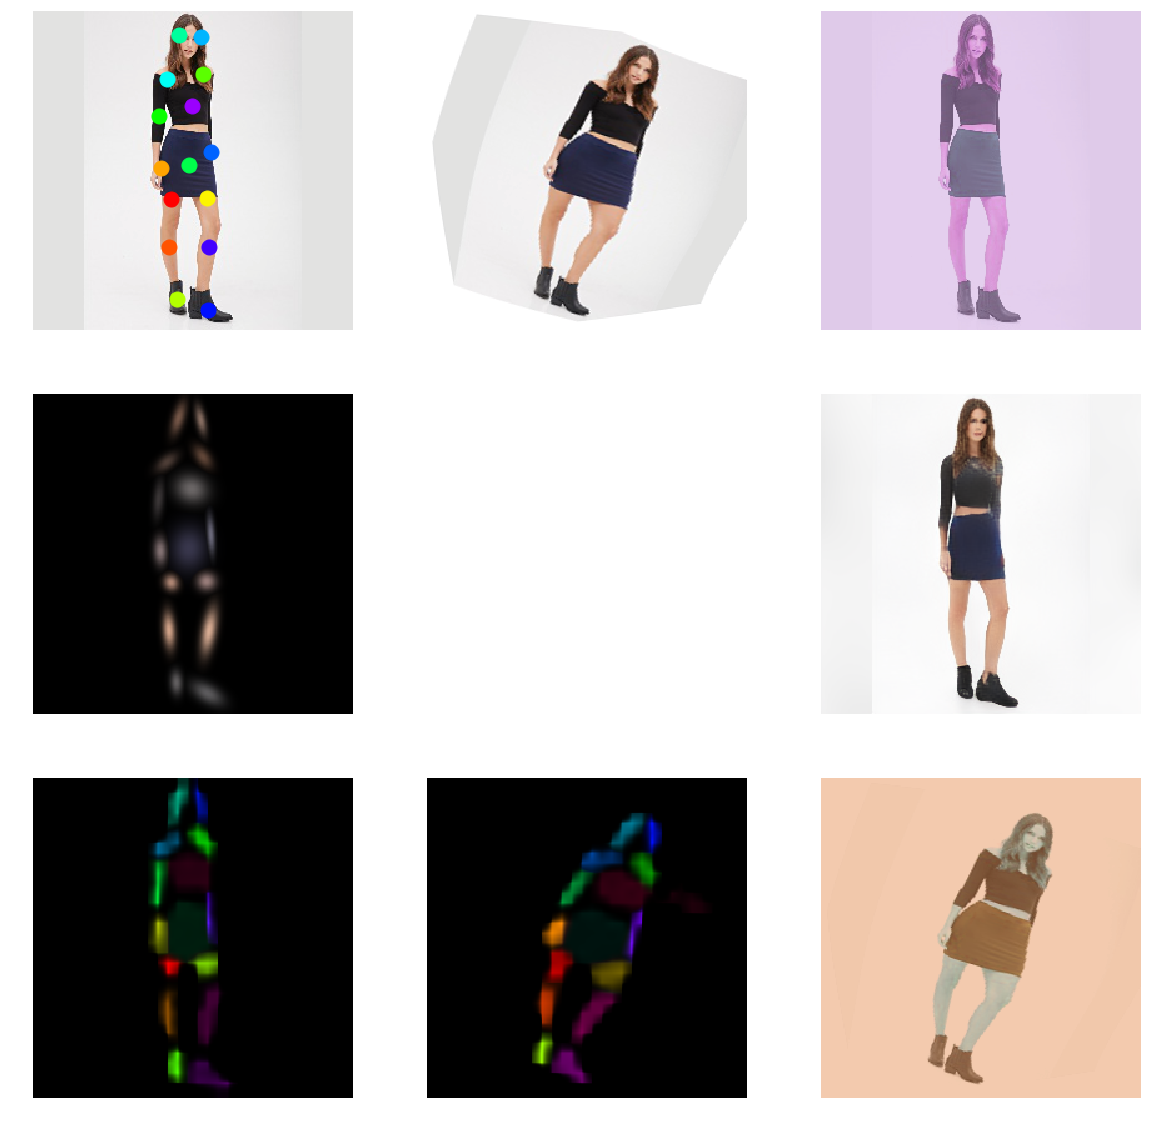

In [3]:
from train_PD import train

# Train
train(df, train_loader, decoder, int_network, num_epochs=epochs, accumulation_steps=accumulation_steps,  filename=  model+"_"+dataset +str(num_joints) )

In [4]:
torch.save(decoder.state_dict(), "saved_models/decoder_"+model+"_" +dataset+ str(num_joints)+".pt")
torch.save(int_network.state_dict(), "saved_models/int_network_"+model+"_"+ dataset+ str(num_joints)+".pt")

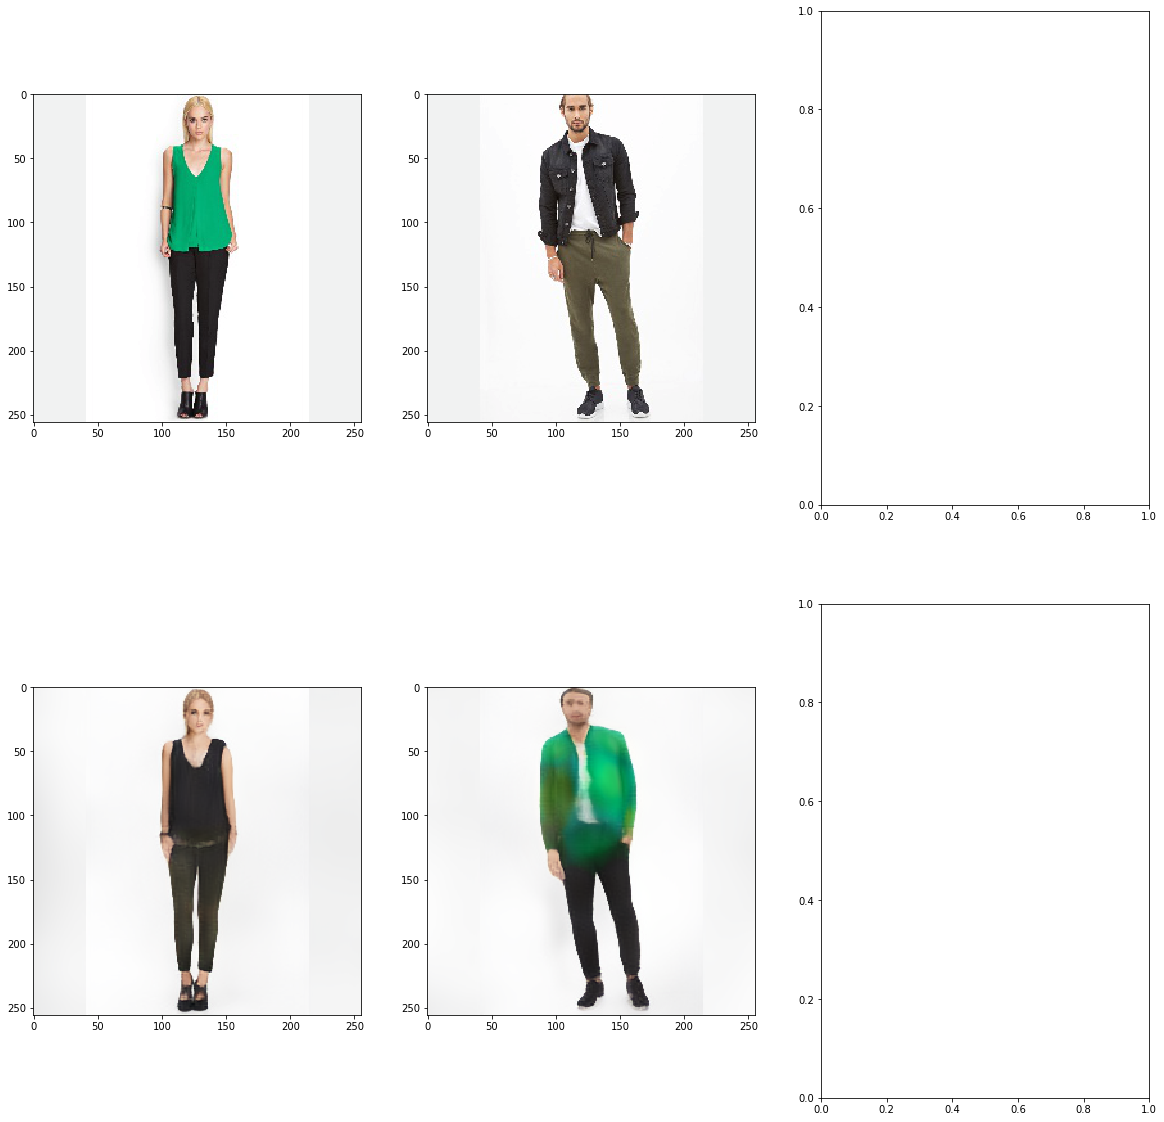

In [3]:
from test_PD import test

decoder.eval()
int_network.eval()

# Test
test(df, test_loader, decoder, int_network)